# EI 3 : Calibration de modèles d'agents

## Part 1 : Calibration

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy
from scipy.stats import t
from scipy.stats import norm
from scipy.optimize import minimize

from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.tsa.stattools

import powerlaw

### Import the data

In [3]:
S = pd.read_csv('data_general_electric.csv', header=None)
S, S.index = S[4], pd.DatetimeIndex(S[0])
S

0
1962-01-02      4.675709
1962-01-03      4.628796
1962-01-04      4.574063
1962-01-05      4.456780
1962-01-08      4.448961
                 ...    
2023-05-19    104.260002
2023-05-22    104.550003
2023-05-23    101.699997
2023-05-24    100.980003
2023-05-25    101.519997
Name: 4, Length: 15456, dtype: float64

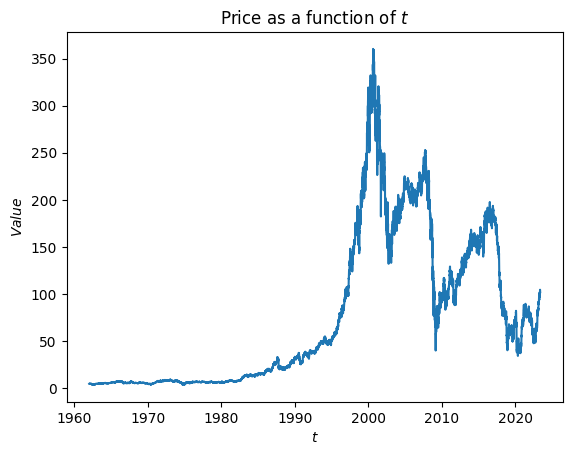

In [4]:
plt.plot(S.index, S)
plt.title("Price as a function of $t$")
plt.xlabel("$t$")
plt.ylabel('$Value$')
plt.show()

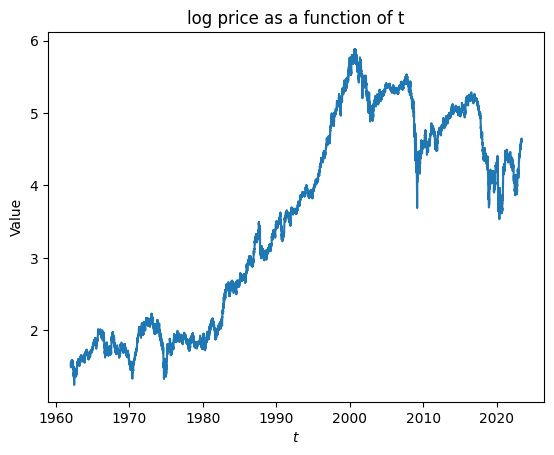

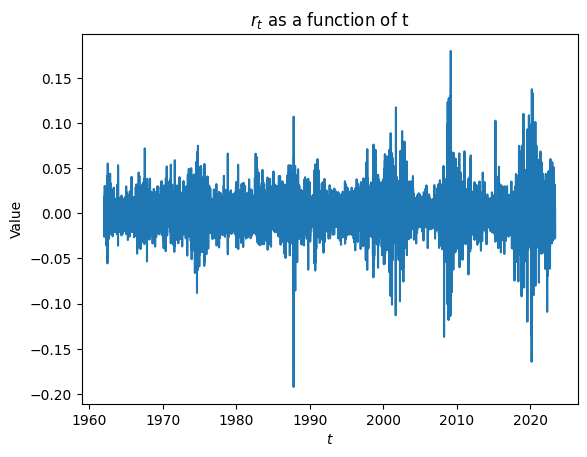

In [5]:
p = np.log(S) #p is the array of log priceplt.plot(p.index[:-1], r)

plt.plot(p.index, p)
plt.title("log price as a function of t")
plt.xlabel("$t$")
plt.ylabel('Value')
plt.show()

r = np.diff(p)

plt.plot(p.index[:-1], r)
plt.title("$r_t$ as a function of t")
plt.xlabel("$t$")
plt.ylabel('Value')
plt.show()

### Implement the model

Model : 

$p_{t+1} - p_t = \kappa_1(v_t-p_t) + \beta\text{tanh}(\gamma m_t)+\varepsilon_t$

$m_t=(1-\alpha)m_{t-1}+\alpha(p_t-p_{t-1})$

$v_t = (1-\lambda)v_{t-1}+\lambda p_t$

Then, the parameters we will try to approach is $\xi=(\kappa_1, \beta, \gamma, \alpha, \lambda, \sigma(\varepsilon))$

In [6]:
def compute_abm(xi, p_0, n, m_0=0, v_0=0):
    """Compute the vector p = [p_0, ..., p_n] with the model of above for a given p_0 value."""
    kappa_1, beta, gamma, alpha, lambda_, sigma = xi
    p = np.zeros(n)
    p[0] = p_0
    epsilon = np.random.normal(0, sigma, n)

    v_t = v_0
    m_t = m_0
    p[1] = p[0] + kappa_1*(v_t - p[0]) + beta*np.tanh(gamma*m_t) + xi[0] + epsilon[1]

    for i in range(1, n - 1):
        m_t = (1 - alpha)*m_t + alpha*(p[i] - p[i - 1])
        v_t = (1 - lambda_)*v_t + lambda_*p[i]
        p[i + 1] = p[i] + kappa_1*(v_t - p[i]) + beta*np.tanh(gamma*m_t) + epsilon[i]

    return p

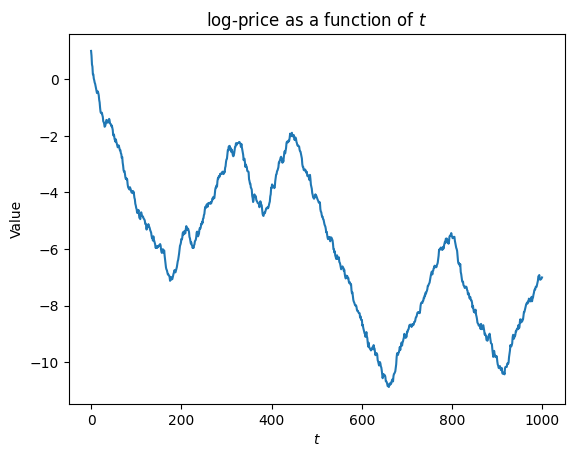

In [7]:
test = compute_abm([0.08, 0.1, 50, 0.1, 0.05, 0.075], 1, 1000)
plt.plot(np.arange(1000), test)
plt.xlabel("$t$")
plt.ylabel("Value")
plt.title("log-price as a function of $t$")
plt.show()

It seems to work well.

### Compute the distance

In [8]:
def compute_dist(p, xi, W):
    r = np.diff(p)
    p_sim = compute_abm(xi, p[0], len(p))    
    r_sim = np.diff(p_sim)
    expectation_difference_vector = np.zeros(len(xi))
    for i in range(len(expectation_difference_vector)):
        expectation_difference_vector[i] = np.mean(r_sim**(i+1)) - np.mean(r**(i+1))
    B = np.dot(W, expectation_difference_vector)
    D = np.dot(np.transpose(expectation_difference_vector), B)
    return D
    # return np.linalg.multi_dot([np.transpose(expectation_difference_vector), W, expectation_difference_vector])

def compute_dist_extended(p, xi, W, nbr_lags):
    r = np.diff(p)
    p_sim = compute_abm(xi, p[0], len(p))    
    r_sim = np.diff(p_sim)
    expectation_difference_vector = np.zeros(len(xi) + nbr_lags)
    for i in range(len(xi)):
        expectation_difference_vector[i] = np.mean(r_sim**(i+1)) - np.mean(r**(i+1))
    r_acf = statsmodels.tsa.stattools.acf(r, nlags=nbr_lags)
    r_acf_sim = statsmodels.tsa.stattools.acf(r_sim, nlags=nbr_lags)
    for j in range(1, nbr_lags + 1):
        expectation_difference_vector[len(xi) - 1 + j] = r_acf[j] - r_acf_sim[j]
    B = np.dot(W, expectation_difference_vector)
    D = np.dot(np.transpose(expectation_difference_vector), B)
    return D

In [9]:
xi_test = [0.35, 3.5, 35, 0.35, 0.35, 0.11]
p_test =  compute_abm(xi_test, 0, 1000)
W_test = np.identity(6)

xi_test_2 = [0.9, 0.9, 0.9, 0.9, 0.9, 1]
xi_test_3 = [1, 1, 1, 1, 1, 0]
print(compute_dist(p_test, xi_test, W_test))
print(compute_dist(p_test, xi_test_2, W_test))
print(compute_dist(p_test, xi_test_3, W_test))

4.1771454610687515
6784.268734098309
12207.430955333763


It seems to work

### Compute the best parameters 

In [10]:
def compute_W_0(r, n):
    """Compute a good matrix W to start the method. The W matrix is of size nxn."""
    M = np.zeros(n)
    for i in range(n):
        M[i] = np.power((np.mean(r**(1 + i))**(-1),2))
    W = np.identity(n)
    for i in range(n):
        W[i, i] = M[i]
    return W

def compute_W_0_extended(r, n, nbr_lags):
    M = np.zeros(n + nbr_lags)
    for i in range(n):
        M[i] = np.power(np.mean(r**(i+ 1))**(-1),2)
    r_acf = statsmodels.tsa.stattools.acf(r, nlags=nbr_lags)
    for i in range(nbr_lags):
        M[i + n] = (1/r_acf[i + 1])**2
    W = np.identity(n + nbr_lags)
    for i in range(n + nbr_lags):
        W[i, i] = M[i]
    return W

In [11]:
def minimize_xi(p, W):
    xi = np.array([scipy.optimize.minimize(lambda xi : compute_dist_extended(p, xi, W, 3), [0.1, 0.5, 1, 0.1, 0.1, 0.05], method="Powell", bounds=[(0.0001, 0.3), (0.001, 0.7), (0.01, 100), (0.01, 0.99), (0.01, 0.99), (0.001, 0.1)], options={"maxiter": 1e6, "disp": False }).x for i in range(10)]).mean(axis=0)
    return xi

p_test = compute_abm([0.08, 0.1, 50, 0.1, 0.05, 0.0], 0, 1000)
W = compute_W_0_extended(np.diff(p_test), 6, 3)
OPT = scipy.optimize.minimize(lambda xi : compute_dist_extended(p, xi, W, 3), [0.1, 0.5, 1, 0.1, 0.1, 0.05], method="Powell", bounds=[(0.0001, 0.3), (0.001, 0.7), (0.01, 100), (0.01, 0.99), (0.01, 0.99), (0.001, 0.1)], options={"maxiter": 1e6, "disp": False })
print(OPT.x)

# plt.plot(np.arange(1000), p_computed, label="Estimation")
# plt.plot(np.arange(1000), p_test, label="Origin")
# plt.legend()
# plt.title("log price as a function of t")
# plt.xlabel("$t$")
# plt.ylabel('Value')
# plt.show()

[1.56645242e-01 4.35115834e-02 5.56994006e+01 7.99012819e-01
 6.46196893e-01 1.18222133e-02]


In [12]:
def compute_W(xi,p):
    P=np.array([compute_abm(xi, p[0], len(p)) for i in range(50)]).mean(axis=0)
    r = np.diff(P)
    data = np.array([r**k for k in range(1, len(xi) + 1)])
    print(data.shape)
    return np.linalg.inv(np.cov(data))

# def compute_W_extended(xi,p):
#     P=np.array([compute_abm(xi, p[0], len(p)) for i in range(50)]).mean(axis=0)
#     r = np.diff(P)
#     data1 = np.array([r**k for k in range(1, len(xi) + 1)])
#     data2 = np.array
#     return np.linalg.inv(np.cov(data))

def compute_W_extended_V2(xi,p, nbr_lags):
    P=np.array([compute_abm(xi, p[0], len(p)) for i in range(100)])
    R = np.array([np.diff(p) for p in P])
    moments = np.array([[r**k for k in range(1, len(xi) +1)] for r in R])
    lags = np.array([statsmodels.tsa.stattools.acf(r, nlags=nbr_lags)[1:] for r in R])
    moments = moments.mean(axis=2)
    
    vector_params = np.concatenate((moments, lags), axis=1)
    vector_params = np.swapaxes(vector_params, 0, 1)

    cov = np.cov(vector_params) + 1e-4
    return np.linalg.inv(cov)

compute_W_extended_V2([0.9]*6,p, 3).shape

(9, 9)

In [13]:
def GMM_iter(p_start, xi_guess, nbr_lags, eps, iter):
    r_start = np.diff(p_start)
    n_param = len(xi_guess)
    W_0 = compute_W_0_extended(r_start, n_param, nbr_lags)
    xi_0 = xi_guess
    xi_1 = minimize_xi(p_start, W_0)
    cpt = 0
    while np.linalg.norm(xi_0 - xi_1) > eps and cpt < iter:
         print("Tour ",cpt)
         xi_0 = xi_1
         W = compute_W_extended_V2(xi_0, p_start, nbr_lags)
         xi_1 = minimize_xi(p_start, W)
         cpt += 1

    return xi_1, np.linalg.norm(xi_0 - xi_1)


In [14]:
xi_test = [0.08, 0.1, 50, 0.1, 0.05, 0.075]

p_test = compute_abm(xi_test, 0, 1000)
#[ 0.1471648 ,  0.33173899, 43.70686279,  0.28573357,  0.58735528, 0.09287031 ]
#1.39614449e-01, 3.71558923e-01, 5.36579726e+01, 4.56077995e-01, 1.43894697e-01, 5.18652670e-02]
xi_mode, dist = GMM_iter(p_test, [0.1, 0.1, 10, 0.1, 0.1, 0.05], 3, 1e-2, 5)
xi_mode = [round(x, 2) for x in xi_mode]
p_mode = np.array([compute_abm(xi_mode, p_test[0], len(p_test)) for i in range(20)]).mean(axis=0)

r_test = np.diff(p_test)
r_mode = np.diff(p_mode)

Tour  0
Tour  1
Tour  2
Tour  3
Tour  4


Distance between last two minimizations :  3.3422297891765997
XI modelised :  [ 0.16  0.39 44.41  0.44  0.16  0.05]
XI test :  [ 0.08   0.1   50.     0.1    0.05   0.075]
|XI_test - XI_mode| =  5.609538751091754


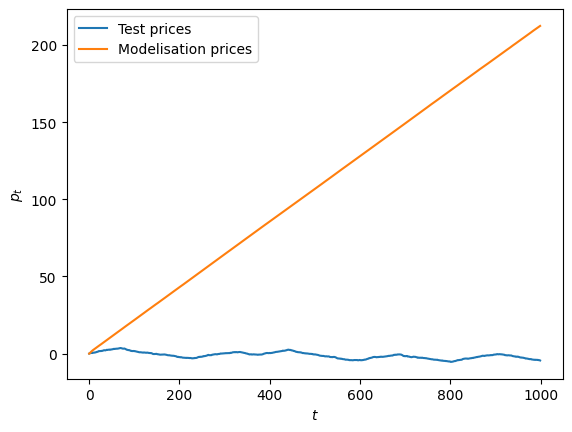

0.25796783737801876
0.2126202834794304


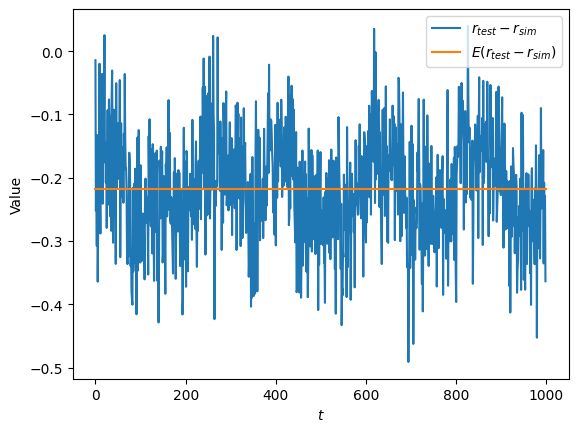

In [15]:
xi_mode = np.array(xi_mode)
xi_test = np.array(xi_test)

print("Distance between last two minimizations : ", dist)
print("XI modelised : ", xi_mode)
print("XI test : ", xi_test)

print("|XI_test - XI_mode| = ", np.linalg.norm(xi_mode-xi_test))

plt.figure()
plt.plot(np.arange(len(p_test)), p_test, label='Test prices')
plt.plot(np.arange(len(p_test)), p_mode, label='Modelisation prices')
plt.legend()
plt.xlabel('$t$')
plt.ylabel('$p_t$')
plt.show()

print(np.max(r_test))
print(np.mean(r_mode))

plt.figure()
plt.plot(np.arange(len(r_test)), (r_test-r_mode), label='$r_{test} - r_{sim}$')
plt.plot([0,1000], [np.mean(r_test-r_mode), np.mean(r_test-r_mode)], label='$E(r_{test} - r_{sim})$')
plt.xlabel('$t$')
plt.ylabel('Value')
plt.legend()
plt.show()

## Part 2 : Investor behaviour

### Exploration

In [16]:
investors_table = pd.read_csv("GAS_Investors.csv")
price_table = pd.read_csv("GAS_Prices.csv", index_col=0)
merged_table = pd.merge(investors_table, price_table, on='date')
merged_table

,investor_id,date,position,close,open,max,min,volume
0,18397,2000-01-03,0.0,22.36,22.87,23.40,22.12,472676
1,18333,2000-01-03,0.0,22.36,22.87,23.40,22.12,472676
2,18322,2000-01-03,-262.0,22.36,22.87,23.40,22.12,472676
3,18321,2000-01-03,0.0,22.36,22.87,23.40,22.12,472676
4,18317,2000-01-03,0.0,22.36,22.87,23.40,22.12,472676
...,...,...,...,...,...,...,...,...
72663,6018,2007-10-16,-3000.0,39.58,38.85,39.95,38.65,1398063
72664,4066,2007-10-16,0.0,39.58,38.85,39.95,38.65,1398063
72665,2963,2007-10-16,0.0,39.58,38.85,39.95,38.65,1398063
72666,2955,2007-10-16,-700.0,39.58,38.85,39.95,38.65,1398063


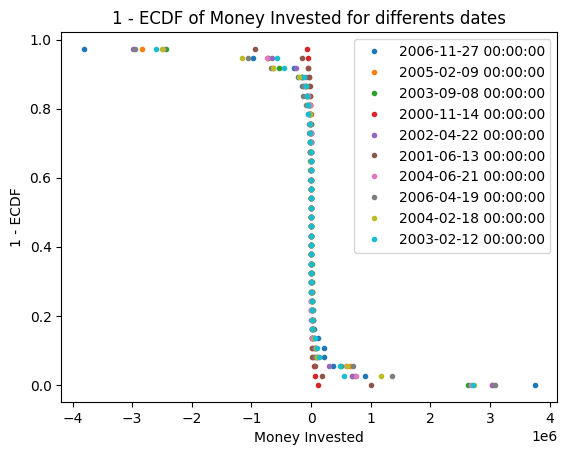

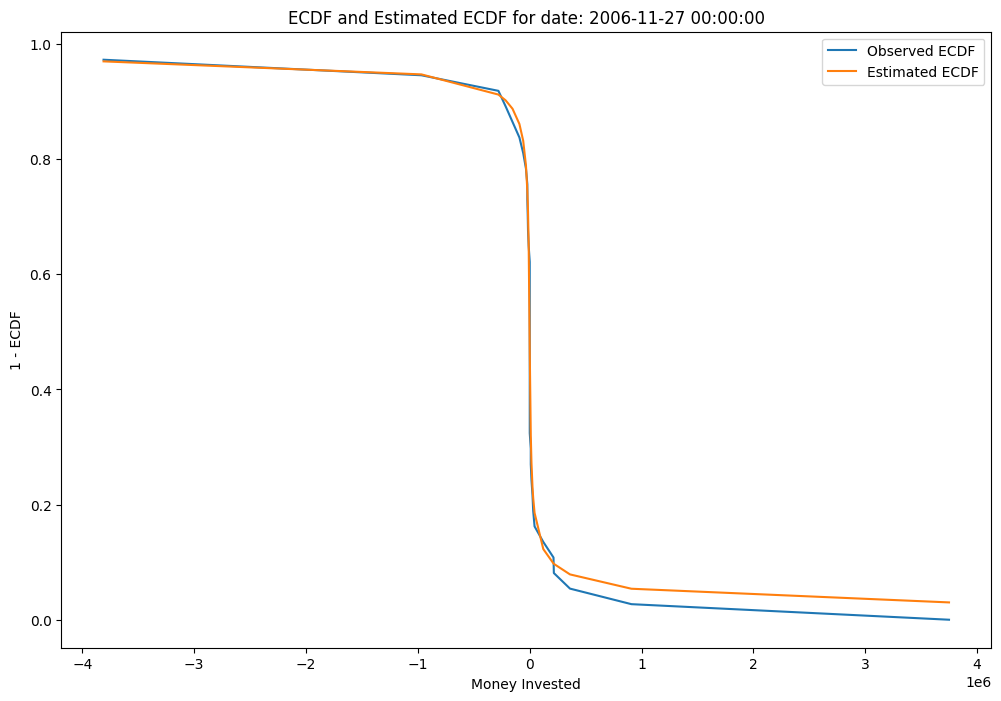

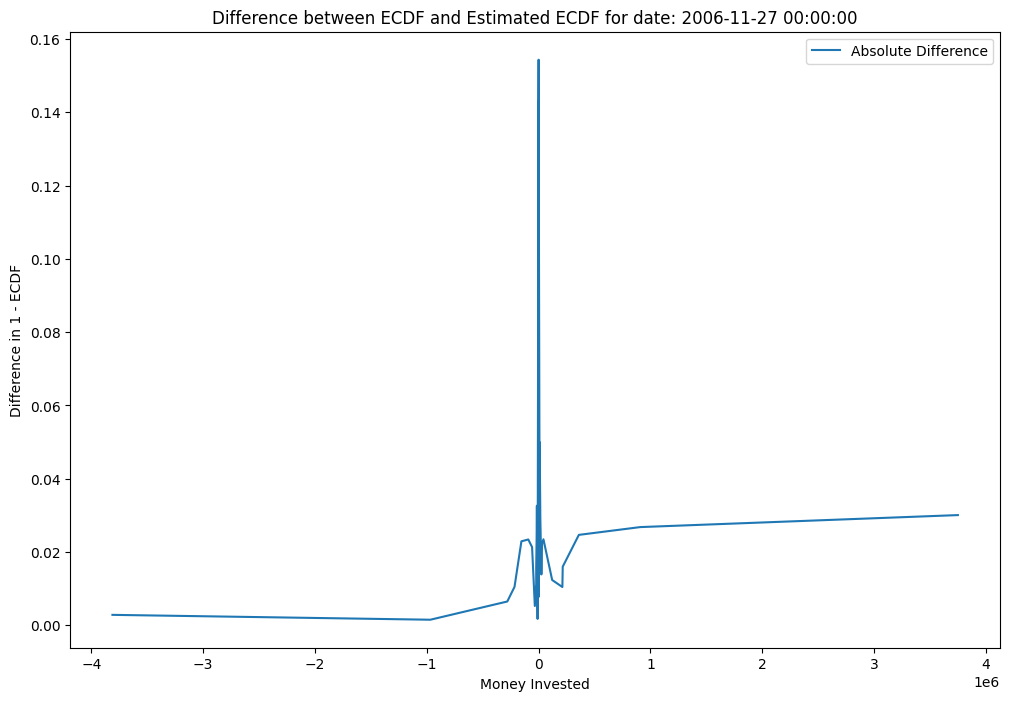

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.3411908954739401
       x: [ 4.112e-01 -1.432e+03  1.104e+04]
     nit: 20
   direc: [[-4.686e-03  1.324e+01 -1.637e+02]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-3.877e-03  1.353e+01 -1.569e+02]]
    nfev: 846


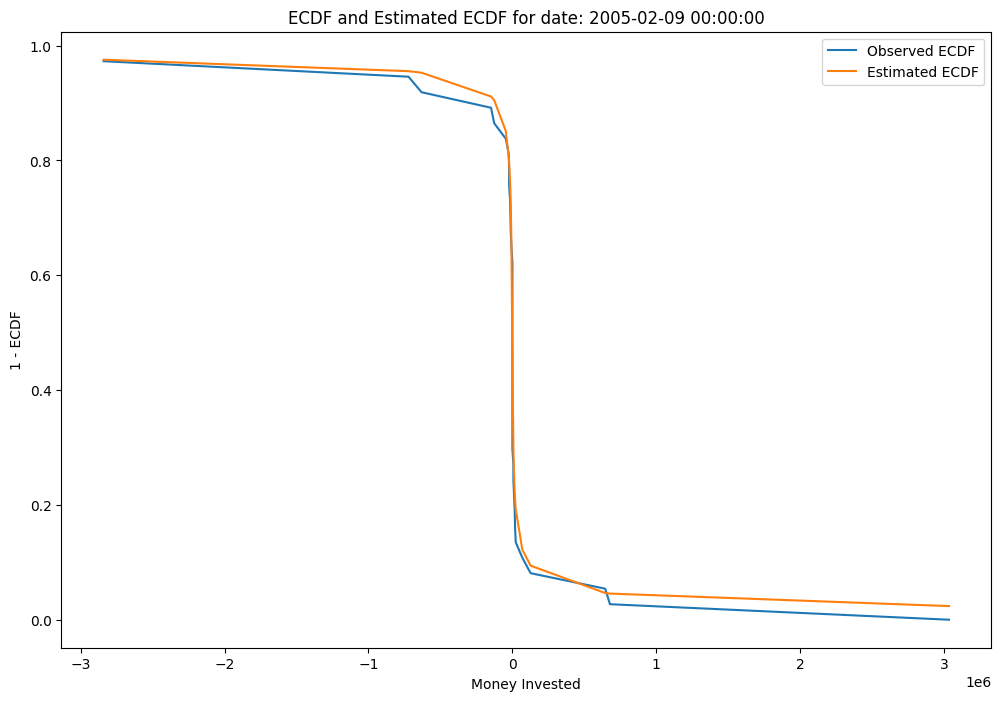

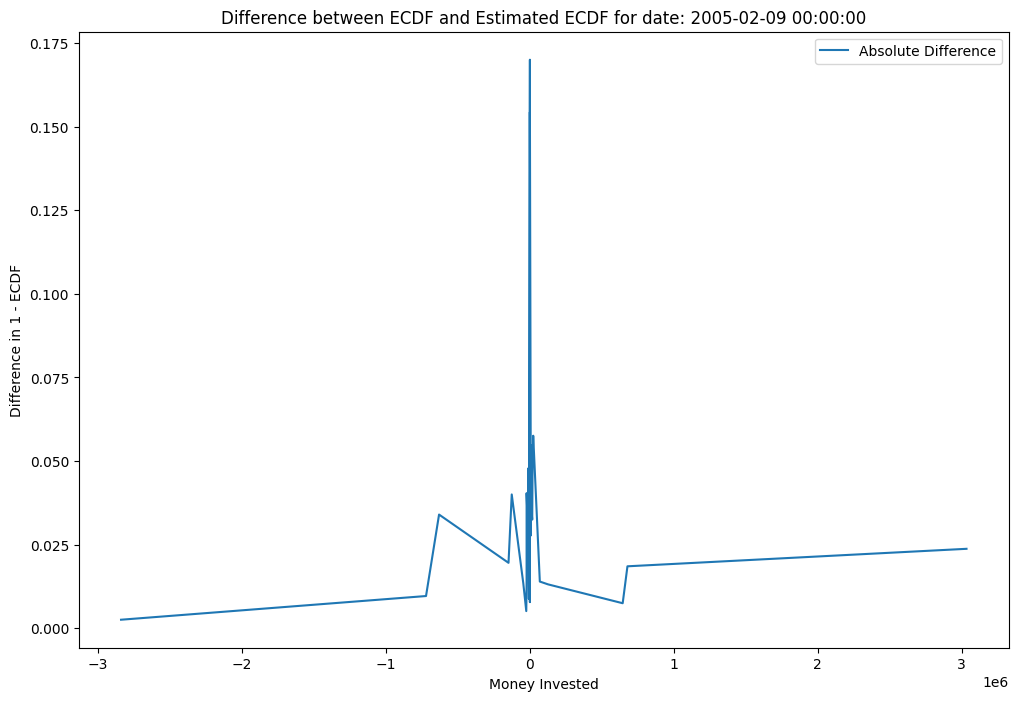

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.3961976209350501
       x: [ 4.347e-01 -1.385e+03  7.266e+03]
     nit: 16
   direc: [[ 1.697e-02 -1.897e+02  9.152e+02]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-1.879e-02  5.518e+01 -3.201e+02]]
    nfev: 654


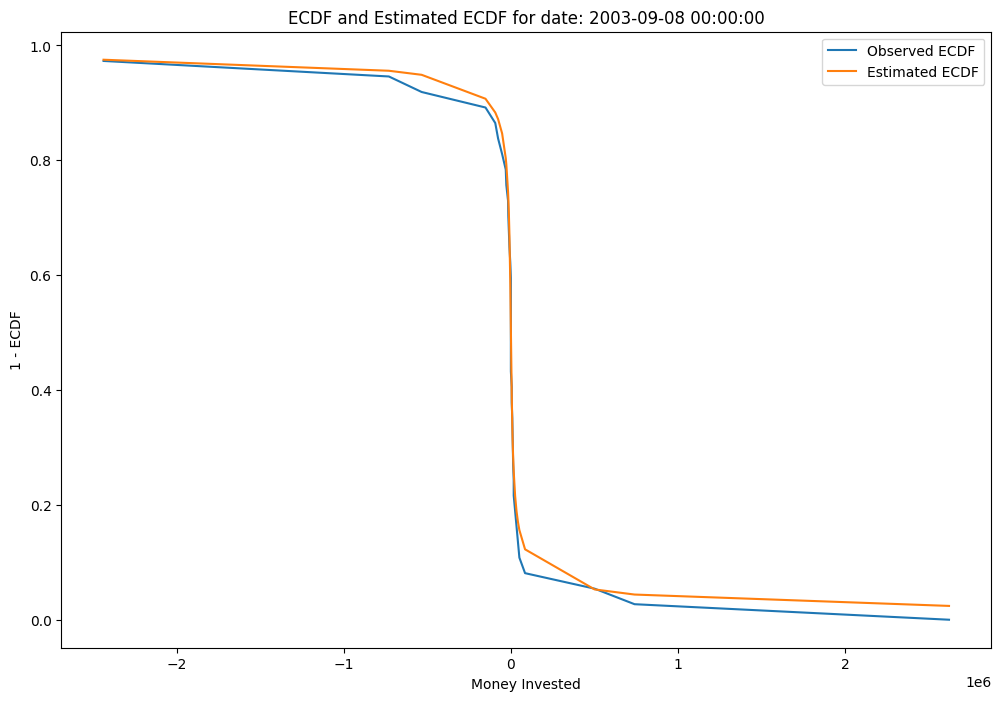

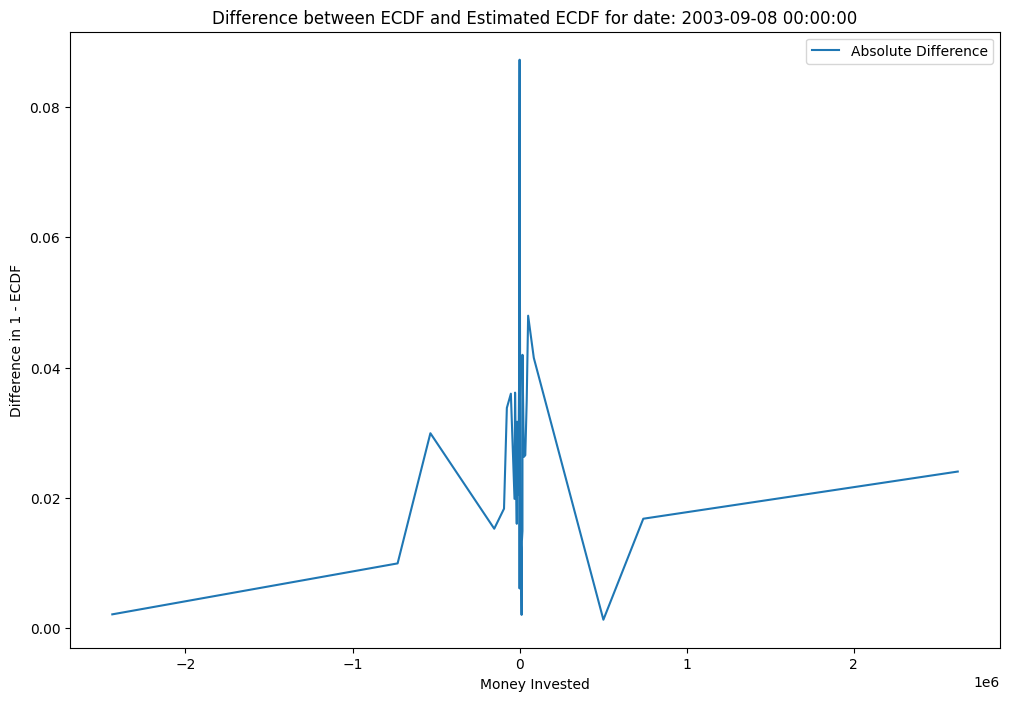

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.20163590476815546
       x: [ 4.747e-01  3.056e+02  1.100e+04]
     nit: 14
   direc: [[ 7.313e-01  8.866e+02  1.330e+04]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 1.527e-01  3.876e+02  5.398e+03]]
    nfev: 567


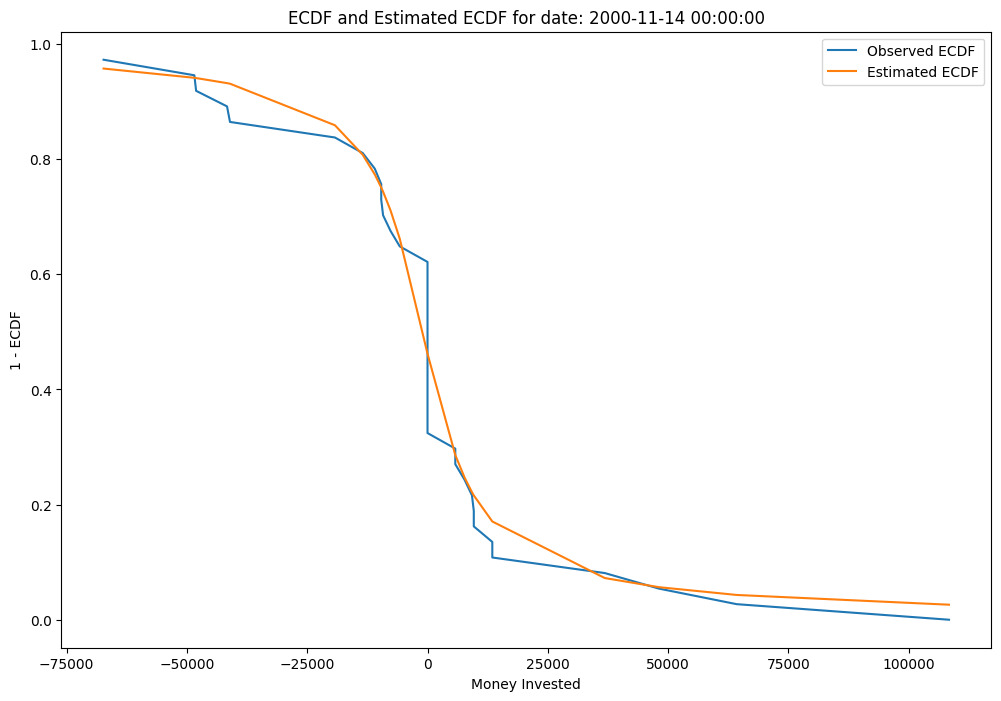

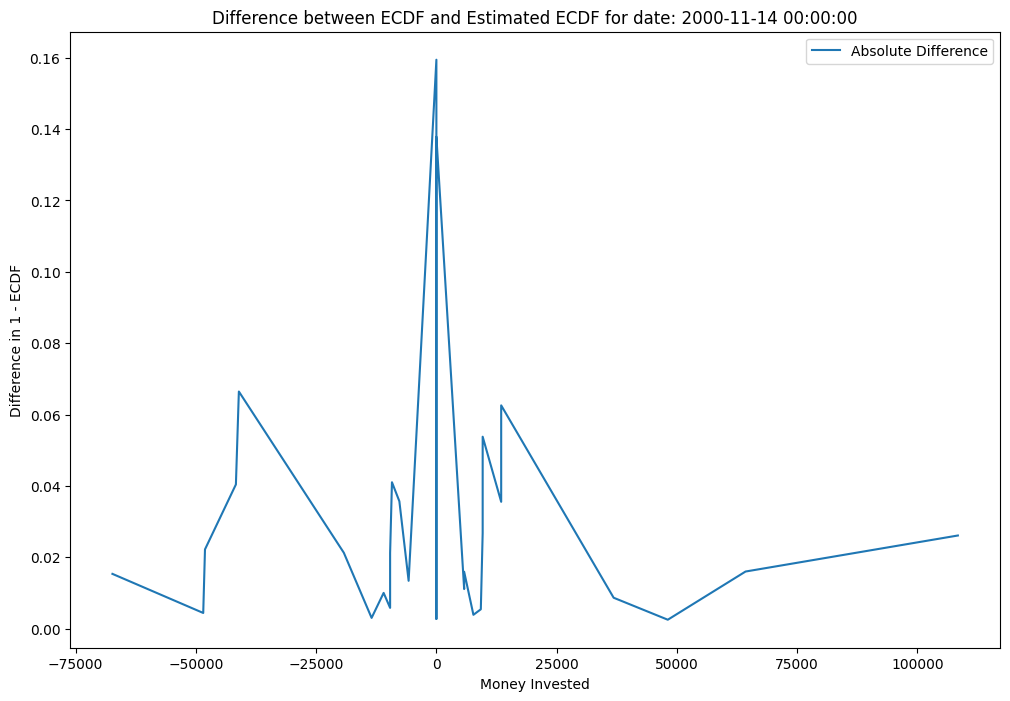

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.3564525195344754
       x: [ 9.746e-01 -1.015e+03  8.461e+03]
     nit: 14
   direc: [[ 1.097e-01 -9.435e+01  6.880e+02]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-3.708e-01  2.664e+02 -8.236e+02]]
    nfev: 556


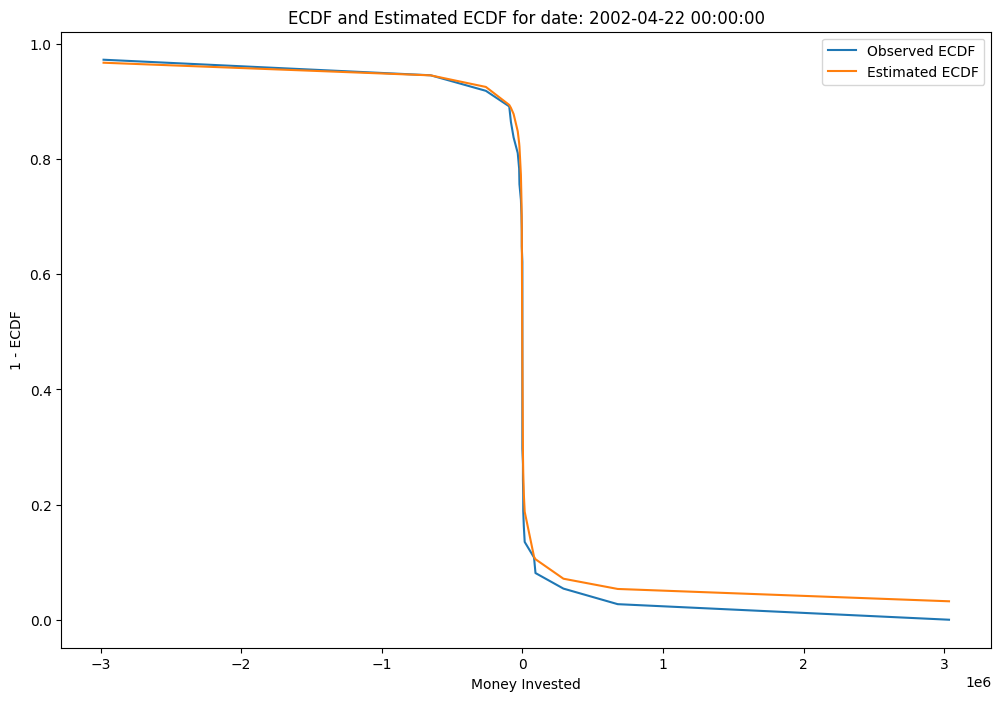

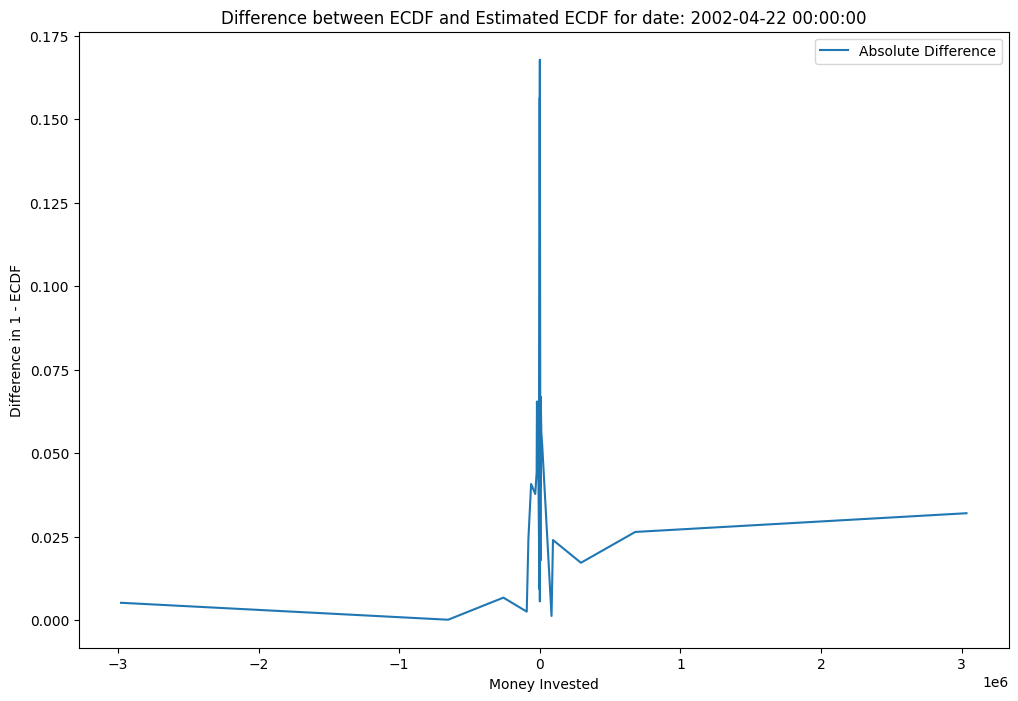

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.40520995271253957
       x: [ 3.419e-01 -5.921e+02  2.998e+03]
     nit: 11
   direc: [[ 1.285e-01 -3.100e+02  1.481e+03]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 1.660e-02 -1.162e+02  6.365e+02]]
    nfev: 445


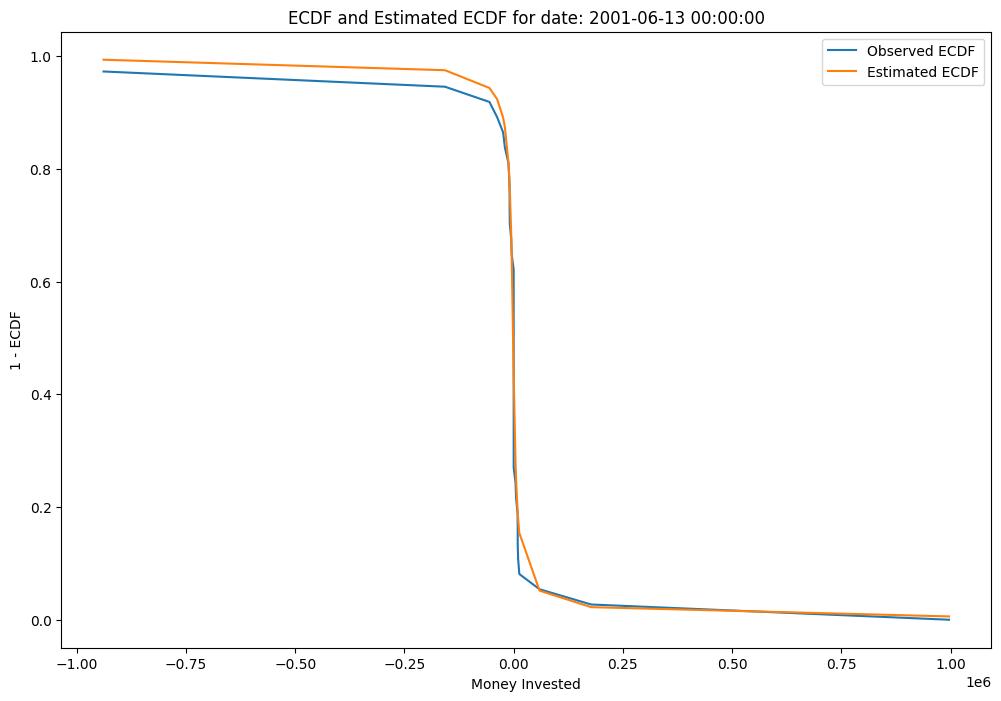

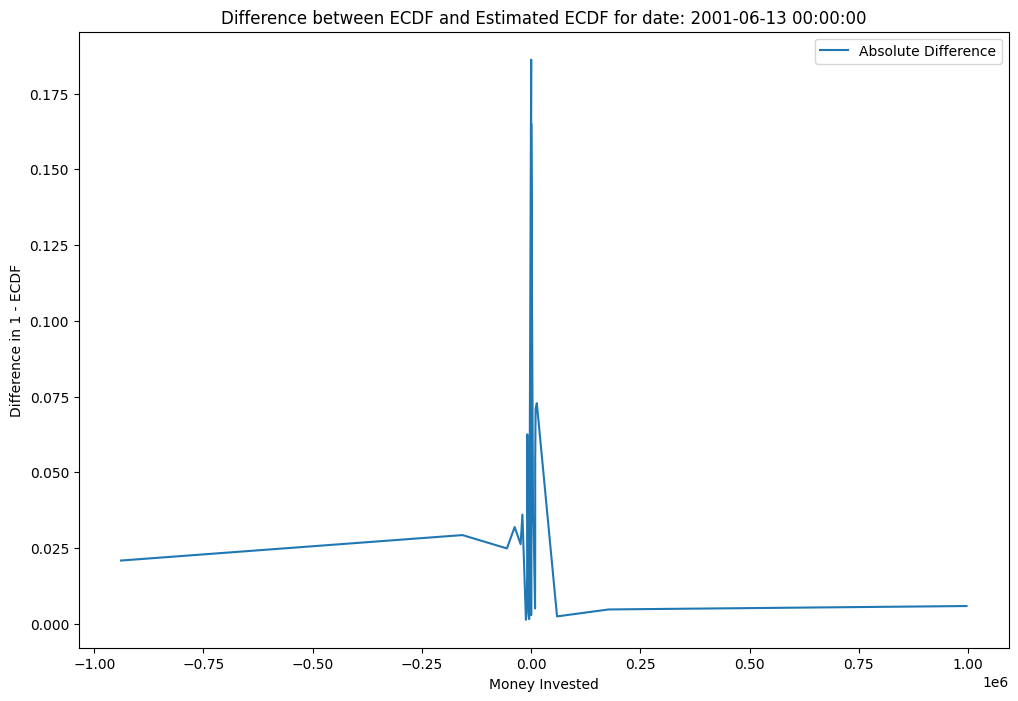

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.4417365564096416
       x: [ 7.771e-01 -1.312e+03  6.027e+03]
     nit: 19
   direc: [[ 3.391e-02 -5.787e+01  2.108e+02]
           [-1.095e-01  1.305e+02 -2.071e+02]
           [-9.768e-02 -1.420e+01 -4.100e+02]]
    nfev: 781


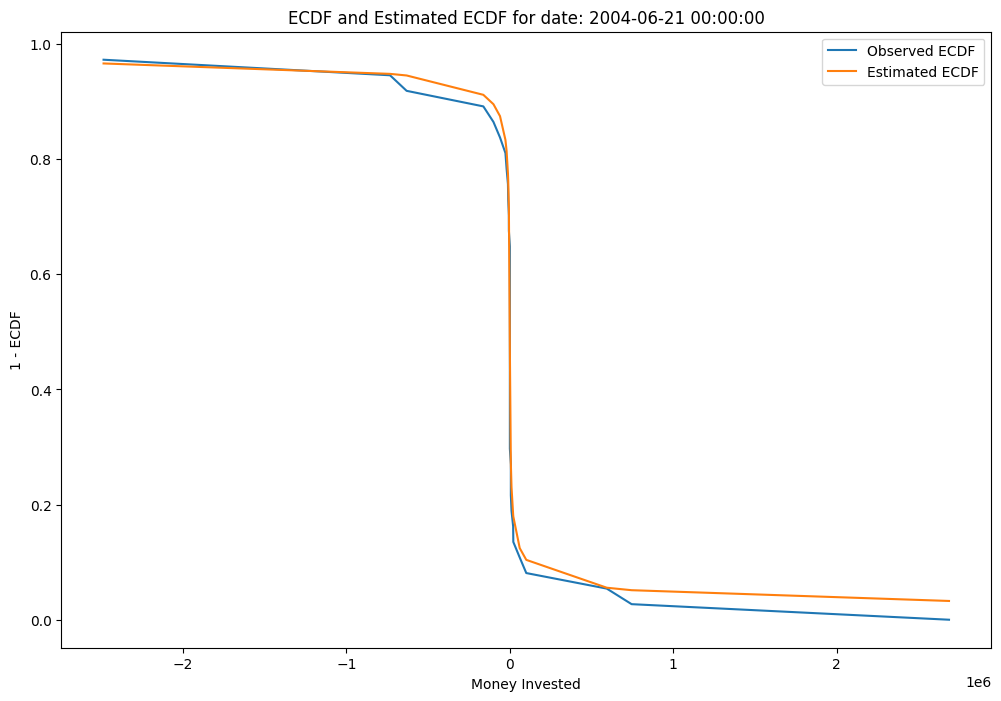

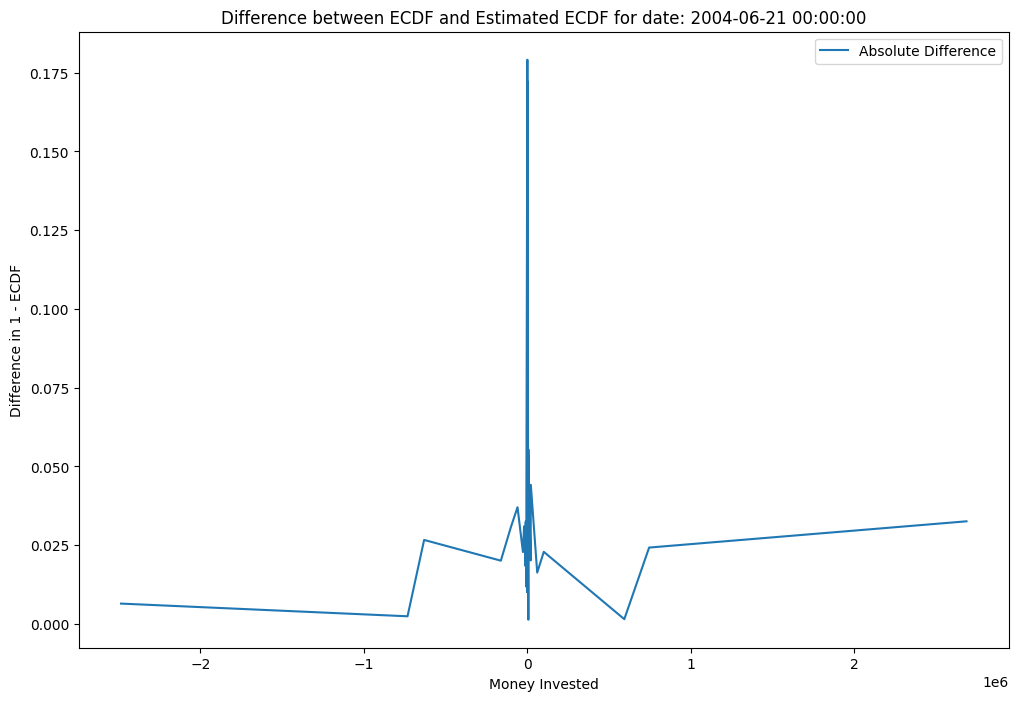

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.4298270742198952
       x: [ 3.535e-01 -4.511e+02  3.555e+03]
     nit: 11
   direc: [[ 1.180e-01 -2.037e+02  1.512e+03]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 2.938e-02 -1.211e+02  1.030e+03]]
    nfev: 440


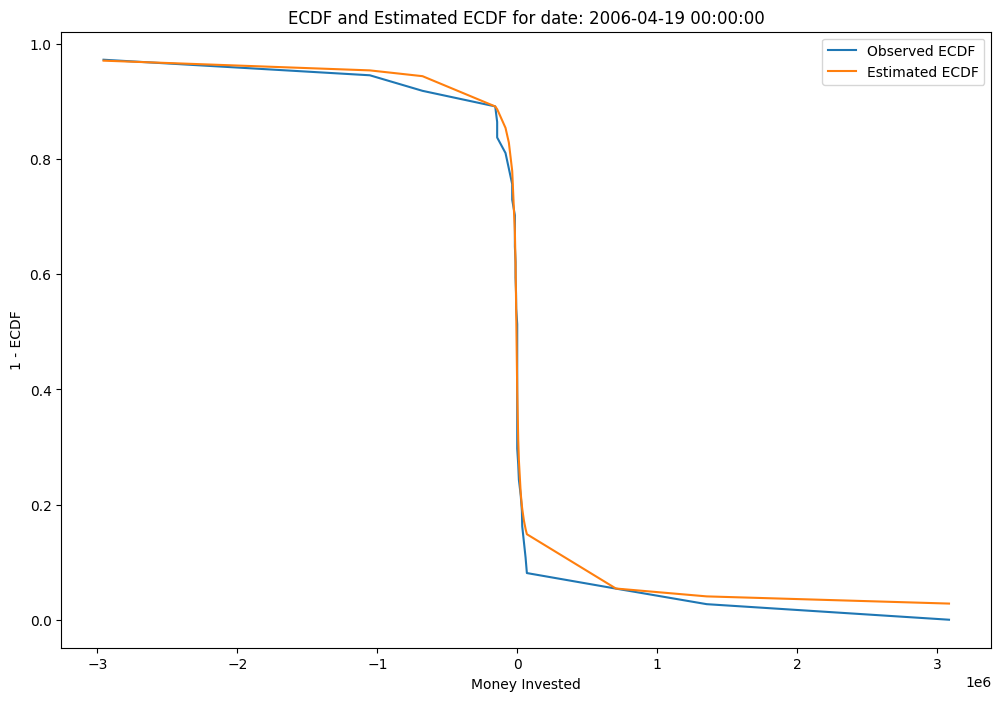

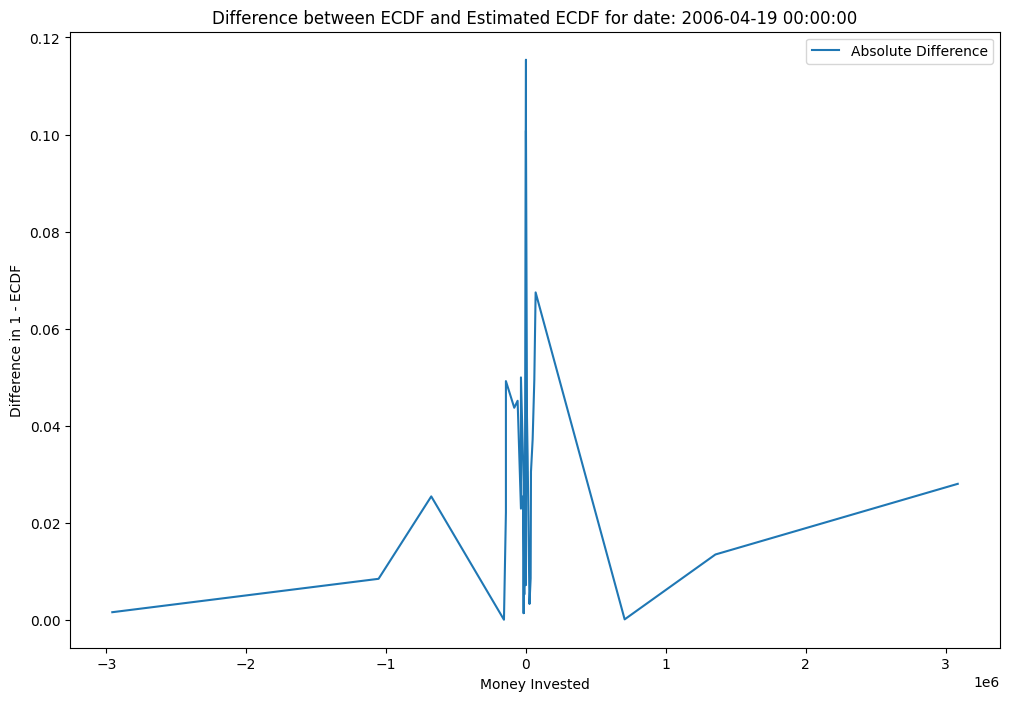

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.26523262271460935
       x: [ 4.479e-01 -5.498e+03  1.295e+04]
     nit: 13
   direc: [[ 3.901e-02  1.022e+02  3.261e+03]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [ 1.484e-03 -7.494e+00  3.290e+01]]
    nfev: 526


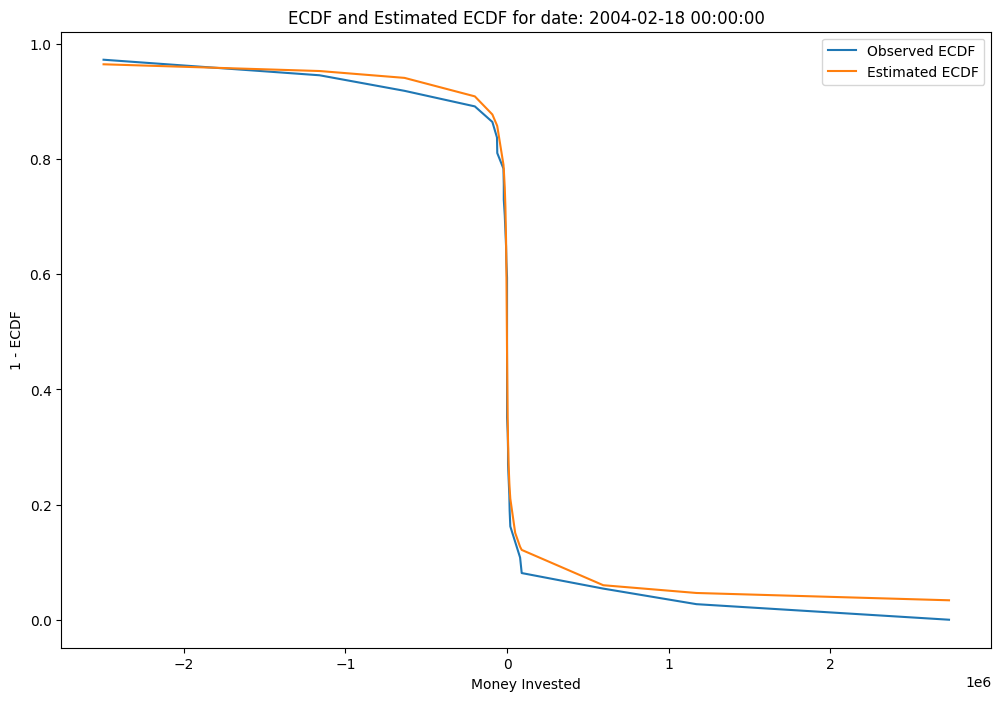

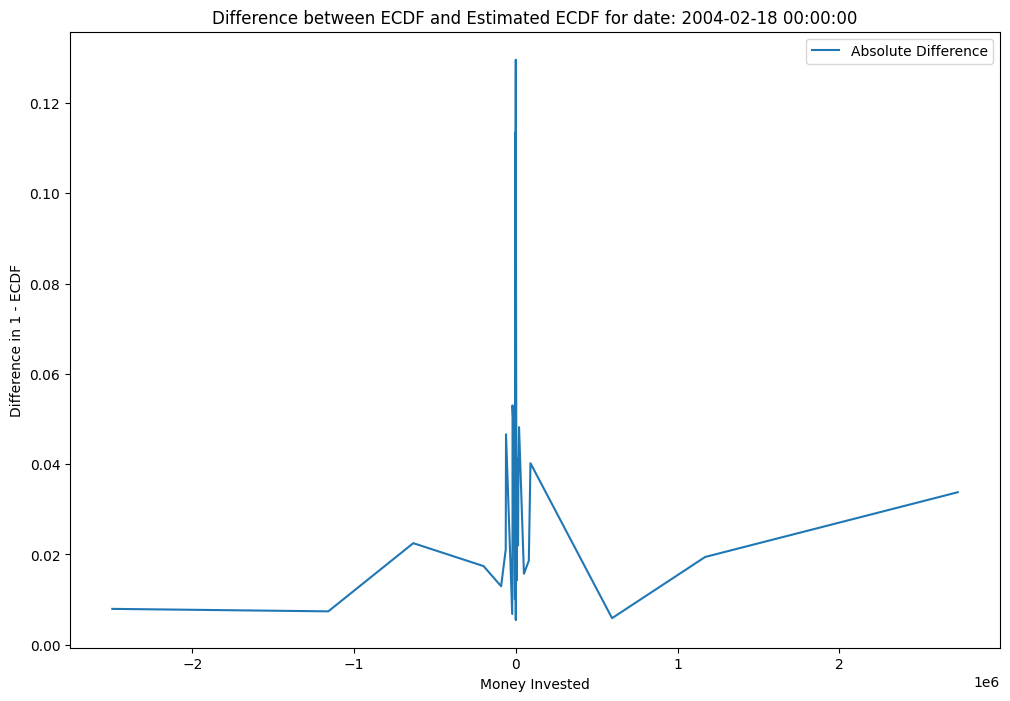

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.28863449205839914
       x: [ 3.765e-01 -8.803e+02  6.146e+03]
     nit: 11
   direc: [[ 2.072e-01 -6.724e+02  4.866e+03]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-5.780e-04 -1.778e+01  1.209e+02]]
    nfev: 443


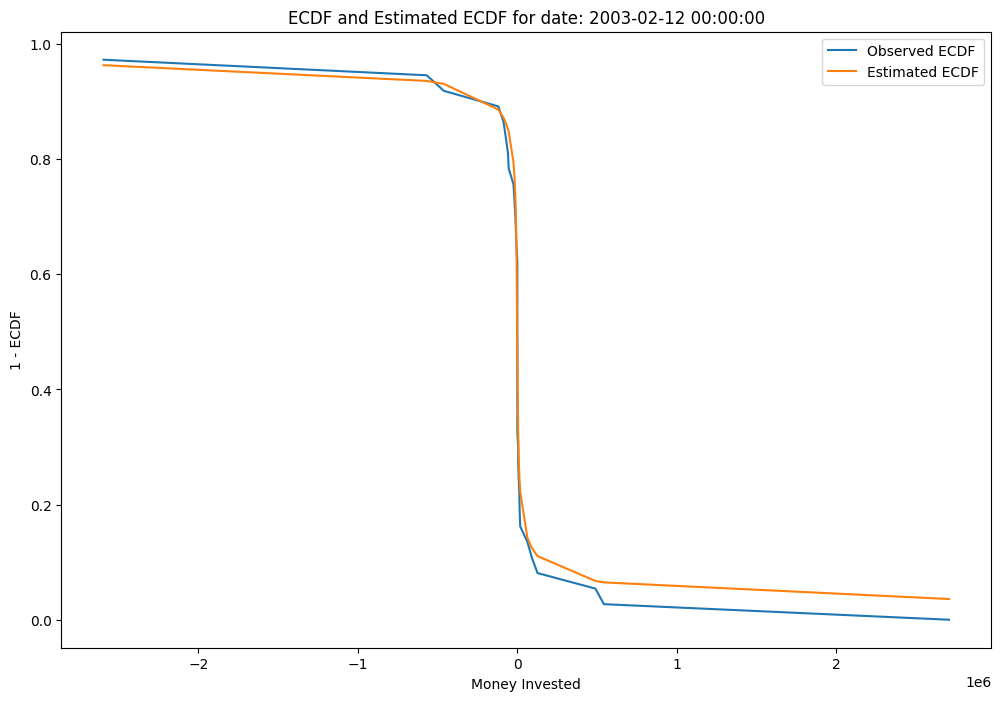

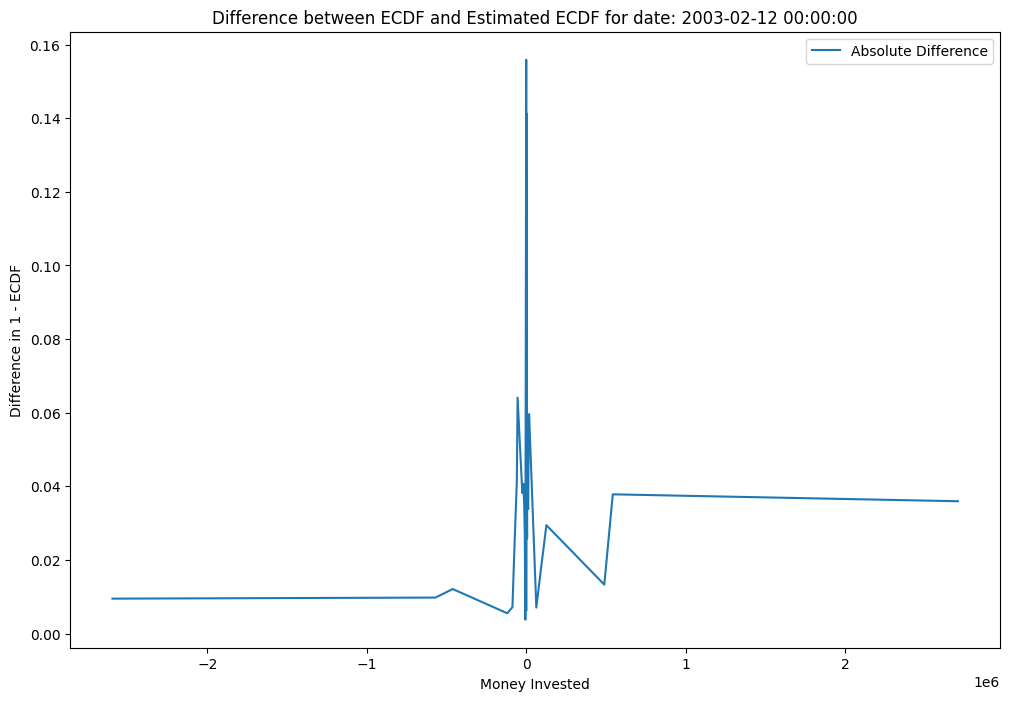

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.36481401809001673
       x: [ 3.674e-01 -8.670e+02  6.138e+03]
     nit: 21
   direc: [[-4.504e-03  9.008e+00 -9.533e+01]
           [ 0.000e+00  1.000e+00  0.000e+00]
           [-4.151e-03  1.249e+01 -1.030e+02]]
    nfev: 884


In [30]:
position_diff = np.diff(merged_table['position'])
position_diff = np.insert(position_diff, 0, 0)

merged_table['money_invested'] = position_diff * merged_table['close']

dates = np.array(list(set(merged_table["date"])))
plt.title(f'1 - ECDF of Money Invested for differents dates')
for specific_date in dates[:10]:
    merged_table_specific_date = merged_table[merged_table['date'] == specific_date]
    ecdf = ECDF(merged_table_specific_date['money_invested'])
    plt.plot(ecdf.x, 1 - ecdf.y, marker='.', linestyle='none', label=str(specific_date))
    plt.xlabel('Money Invested')
    plt.ylabel('1 - ECDF')
plt.legend()
plt.show()

def objective(params, X, Y):
    df, loc, scale= params
    Y = np.array(Y)
    Y2 = (1 - t.cdf(X, df=df, loc=loc, scale=scale))
    return np.linalg.norm(Y-Y2)

for specific_date in dates[:10]:
    merged_table_specific_date = merged_table[merged_table['date'] == specific_date]
    ecdf = ECDF(merged_table_specific_date['money_invested'])
    X = ecdf.x
    Y = 1 - ecdf.y
    init_params = [1.0, 0.0, 1.0]  # Initial parameters for the t-distribution
    result = minimize(objective, init_params, args=(X, Y), method="Powell", bounds=[(1e-6, None), (None, None), (1e-6, None)])

    df_optimized, loc_optimized, scale_optimized = result.x

    Y_estimated = 1 - t.cdf(X, df=df_optimized, loc=loc_optimized, scale=scale_optimized)

    plt.figure(figsize=(12, 8))
    plt.plot(X, Y, label='Observed ECDF')
    plt.plot(X, Y_estimated, label='Estimated ECDF')
    plt.xlabel('Money Invested')
    plt.ylabel('1 - ECDF')
    plt.title('ECDF and Estimated ECDF for date: ' + str(specific_date))
    plt.legend()
   
    plt.figure(figsize=(12, 8))
    plt.plot(X, np.abs(Y - Y_estimated), label='Absolute Difference')
    plt.xlabel('Money Invested')
    plt.ylabel('Difference in 1 - ECDF')
    plt.title('Difference between ECDF and Estimated ECDF for date: ' + str(specific_date))
    plt.legend()

    plt.show()

    print(result)

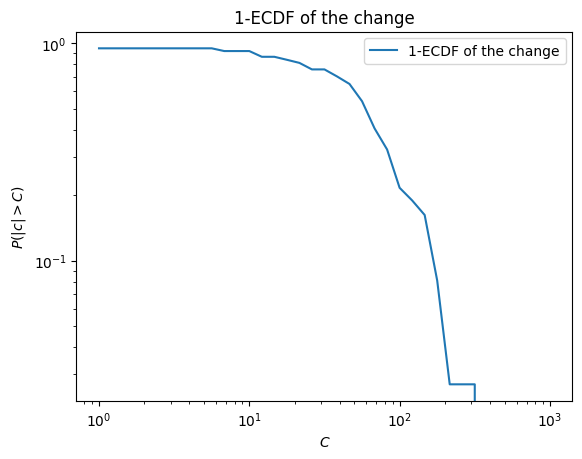

In [18]:
investors_table = investors_table.sort_values(['investor_id', 'date'])
investors_table['position_diff'] = investors_table.groupby('investor_id')['position'].diff()
investor_changes = investors_table[investors_table['position_diff'] != 0].groupby('investor_id')['position_diff'].count()

ecdf = ECDF(investor_changes, side='left')

T = np.linspace(0, 3, len(investor_changes))
T= 10**T

plt.plot(T, 1 - ecdf(T), label="1-ECDF of the change")
plt.title('1-ECDF of the change')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$C$')
plt.ylabel('$P(|c|>C)$')
plt.show()

In [21]:
c = powerlaw.Fit(1 - ecdf(T), verbose=False).alpha
c

4.354285621893007

### Influence of past price returns

In [22]:
investors_table = merged_table

investors_table['return'] = (investors_table['close'] - investors_table['open']) / investors_table['open']
investors_table['inventory_change'] = investors_table.groupby('investor_id')['position'].diff()

investors_table_grouped = investors_table.groupby('investor_id').apply(lambda x: np.corrcoef(x['inventory_change'][1:], x['return'][1:])[0, 1])

def classify_investor(corr):
    if np.isclose(corr, 0, atol=0.05):  # correlation is close to 0
        return 'neutral'
    elif corr > 0:  # correlation is positive
        return 'trend-following'
    else:  # correlation is negative
        return 'mean-reverting'

investors_table_grouped = investors_table_grouped.apply(classify_investor)

print(investors_table_grouped)
counts = investors_table_grouped.value_counts()
print(counts)

investor_id
744      mean-reverting
2955            neutral
2963     mean-reverting
4066     mean-reverting
6018     mean-reverting
6198     mean-reverting
6447     mean-reverting
7319     mean-reverting
7936            neutral
9176     mean-reverting
9185     mean-reverting
9190     mean-reverting
9191     mean-reverting
10510    mean-reverting
10649           neutral
10710           neutral
11513           neutral
11872           neutral
14561           neutral
14774           neutral
15724    mean-reverting
15740    mean-reverting
15814           neutral
15936    mean-reverting
16433    mean-reverting
17837    mean-reverting
18159    mean-reverting
18169    mean-reverting
18178           neutral
18195           neutral
18228           neutral
18232           neutral
18317           neutral
18321    mean-reverting
18322           neutral
18333           neutral
18397    mean-reverting
dtype: object
mean-reverting    21
neutral           16
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [23]:
investors_table['date'] = pd.to_datetime(investors_table['date'])
median_date = investors_table['date'].median()

# Create two DataFrames for the two periods
investors_table_first_period = investors_table[investors_table['date'] < median_date]
investors_table_second_period = investors_table[investors_table['date'] >= median_date]

# Classify investors for the first period
investors_table_first_period['return'] = (investors_table_first_period['close'] - investors_table_first_period['open']) / investors_table_first_period['open']
investors_table_first_period['inventory_change'] = investors_table_first_period.groupby('investor_id')['position'].diff()
investors_table_grouped_first = investors_table_first_period.groupby('investor_id').apply(lambda x: np.corrcoef(x['inventory_change'][1:], x['return'][1:])[0, 1])
investors_table_grouped_first = investors_table_grouped_first.apply(classify_investor)

# Classify investors for the second period
investors_table_second_period['return'] = (investors_table_second_period['close'] - investors_table_second_period['open']) / investors_table_second_period['open']
investors_table_second_period['inventory_change'] = investors_table_second_period.groupby('investor_id')['position'].diff()
investors_table_grouped_second = investors_table_second_period.groupby('investor_id').apply(lambda x: np.corrcoef(x['inventory_change'][1:], x['return'][1:])[0, 1])
investors_table_grouped_second = investors_table_grouped_second.apply(classify_investor)

# Combine the results from both periods into one DataFrame
investors_table_transitions = pd.concat([investors_table_grouped_first, investors_table_grouped_second], axis=1)
investors_table_transitions.columns = ['first_period', 'second_period']

# Compute the transition table
transition_table = pd.crosstab(investors_table_transitions['first_period'], investors_table_transitions['second_period'], normalize='index')

print(transition_table)

second_period   mean-reverting   neutral  trend-following
first_period                                             
mean-reverting        0.739130  0.217391         0.043478
neutral               0.571429  0.357143         0.071429


/var/folders/4c/2cw0jjvs6nb5v4xdxk3ty9s40000gn/T/ipykernel_71307/536059611.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  investors_table_first_period['return'] = (investors_table_first_period['close'] - investors_table_first_period['open']) / investors_table_first_period['open']
/var/folders/4c/2cw0jjvs6nb5v4xdxk3ty9s40000gn/T/ipykernel_71307/536059611.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  investors_table_first_period['inventory_change'] = investors_table_first_period.groupby('investor_

In [24]:
investors_table['return'] = (investors_table['close'].shift(-1) - investors_table['open'].shift(-1)) / investors_table['open'].shift(-1)
investors_table['inventory_change'] = investors_table.groupby('investor_id')['position'].diff()

investors_table_grouped_futur = investors_table.groupby('investor_id').apply(lambda x: np.corrcoef(x['inventory_change'][1:], x['return'][:-1])[0, 1])

def classify_investor(corr):
    if np.isclose(corr, 0, atol=0.05):  # correlation is close to 0
        return 'neutral'
    elif corr > 0:  # correlation is positive
        return 'trend-following'
    else:  # correlation is negative
        return 'mean-reverting'

investors_table_grouped_futur = investors_table_grouped_futur.apply(classify_investor)

print(investors_table_grouped_futur)
counts = investors_table_grouped_futur.value_counts()
print(counts)

investor_id
744       mean-reverting
2955             neutral
2963             neutral
4066             neutral
6018             neutral
6198      mean-reverting
6447      mean-reverting
7319             neutral
7936     trend-following
9176             neutral
9185             neutral
9190             neutral
9191      mean-reverting
10510            neutral
10649            neutral
10710            neutral
11513            neutral
11872            neutral
14561            neutral
14774            neutral
15724            neutral
15740    trend-following
15814            neutral
15936            neutral
16433            neutral
17837     mean-reverting
18159            neutral
18169            neutral
18178            neutral
18195    trend-following
18228            neutral
18232            neutral
18317            neutral
18321     mean-reverting
18322     mean-reverting
18333            neutral
18397     mean-reverting
dtype: object
neutral            26
mean-reverting      8
trend

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Part 3 : Prediction with an ABM

### Functions of prediction

In [140]:
model = p
WINDOW_LENGTH = 100
DEFAULT_MODEL = np.array([0.1, 0.1, 10, 0.1, 0.1, 0.05])
LAGS_NUMBER = 3

def get_window(model, present_t, length):
    """Return an array of the model but between the interval [present_t - lenght, present-t]."""
    if present_t > length :
        return model[present_t-length:present_t+1]
    else:
        return model[:present_t+1]
    

def get_next_values(model, present_t, length, n):
    """Return n next values using the GMM method with the "lenght" last values."""
    sliced_model = get_window(model, present_t, length)
    fitted_parameters, dist = GMM_iter(sliced_model, DEFAULT_MODEL, LAGS_NUMBER, 1e-2, 5)
    alpha = fitted_parameters[4]
    lambda_ = fitted_parameters[5]
    m_t = 0
    v_t = 0
    for i in range(present_t-length + 1, present_t):
        m_t = (1 - alpha)*m_t + alpha*(model[i] - model[i - 1])
        v_t = (1 - lambda_)*v_t + lambda_*model[i]
    return compute_abm(fitted_parameters, model[present_t], n + 1, m_t, v_t)[1:]

# print(np.append(p, get_next_values(np.array(p), 1000, 50, 1)).shape)

def get_prediction(model, length, n, stationary=True, delta_t=10):
    """Precict the n next values using the GMM method with the "length" last values. Returns the model + the estimated values."""
    if stationary:
        for _ in range(n):
            next_value = get_next_values(model, len(model) - 1, length, 1)[-1]
            model = np.append(model, next_value)
        return model
    else:
        for _ in range(n//delta_t):
            next_values = get_next_values(model, len(model) - 1, length, delta_t)
            model = np.append(model, next_values)
        if n%delta_t != 0:
            next_values = get_next_values(model, len(model) - 1, length, n%delta_t)
            model = np.append(model, next_values)
        return model
    
# print(get_prediction(p, 50, 1, False, 50).shape)
# print(len(p) + 1)

### Difference between realistic and predicted models 

In [52]:
T = 1000
XI_TEST = [0.08, 0.1, 50, 0.1, 0.05, 0.075]

ABM_test = compute_abm(XI_TEST, 3, 2*T)
ABM_predicted = ABM_test[:1000]
ABM_predicted = get_prediction(ABM_predicted, T , 15)


Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4


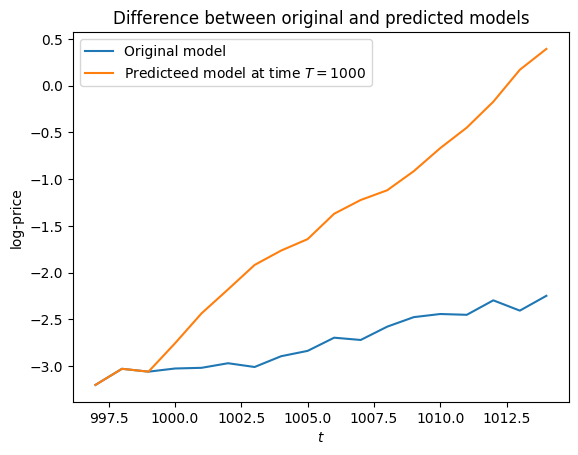

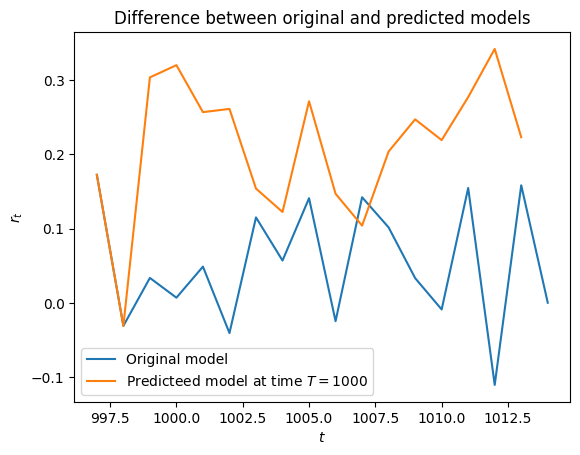

In [65]:
plt.plot(np.arange(T - 3, T - 3 + len(ABM_test[T - 3: T + 15])), ABM_test[T - 3: T + 15], label="Original model")
plt.plot(np.arange(T - 3, T - 3 + len(ABM_test[T - 3: T + 15])), ABM_predicted[T - 3: T + 15], label="Predicteed model at time $T=1000$")
plt.title("Difference between original and predicted models")
plt.xlabel("$t$")
plt.ylabel("log-price")
plt.legend()
plt.show()

R_ABM_test = np.diff(ABM_test)
R_ABM_predicted = np.diff(ABM_predicted)

plt.plot(np.arange(T - 3, T - 3 + len(R_ABM_test[T - 3: T + 15])), R_ABM_test[T - 3: T + 15], label="Original model")
plt.plot(np.arange(T - 3, T - 3 + len(R_ABM_predicted[T - 3: T + 15])), R_ABM_predicted[T - 3: T + 15], label="Predicteed model at time $T=1000$")
plt.title("Difference between original and predicted models")
plt.xlabel("$t$")
plt.ylabel("$r_t$")
plt.legend()
plt.show()

In [141]:
dict = {(True,True): 0, (True,False) : 0, (False,True) : 0, (False,False) : 0}

for day in range(T - 1, T + 14):
    bool2 = R_ABM_test[day] > 0
    bool1 = R_ABM_predicted[day] > 0
    dict[(bool1,bool2)]+=1

data = {"True for predicted model": [dict[(True,True)], dict[(True,False)]], "False for predicted model": [dict[(False,True)], dict[(False,False)]]}

table = pd.DataFrame.from_dict(data, orient="index", columns=["True for real model", "False for real model"])
print(table)

precision = dict[(True,True)] / (dict[(True,True)] + dict[(True,False)])
print("Precision = " + str(precision))

hit_ratio = dict[(True,True)] / (dict[(True,True)] + dict[(False,False)])
print("Hit ratio = " + str(hit_ratio))

                           True for real model  False for real model
True for predicted model                    11                     4
False for predicted model                    0                     0
Precision = 0.7333333333333333
Hit ratio = 1.0


In [152]:
T = 1000
XI_TEST = [0.08, 0.1, 50, 0.1, 0.05, 0.075]

ABM_test_2 = compute_abm(XI_TEST, 3, 2*T)
ABM_predicted_2 = ABM_test[:1000]
ABM_predicted_2 = get_prediction(ABM_predicted_2, 50 , T, False, 100)

Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4


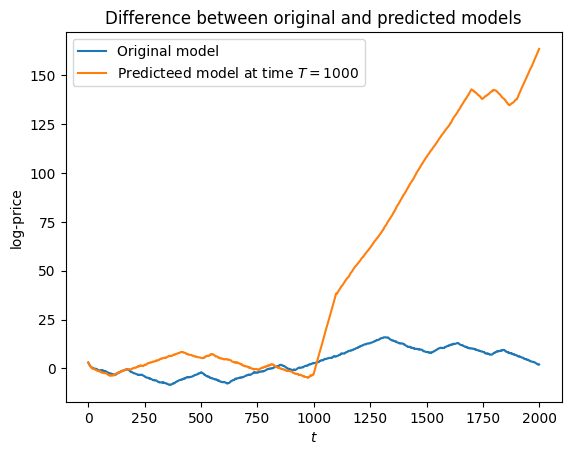

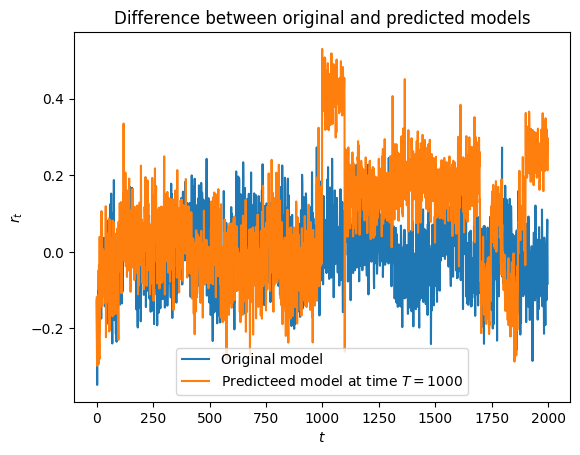

In [155]:
plt.plot(np.arange(len(ABM_test_2)), ABM_test_2, label="Original model")
plt.plot(np.arange(len(ABM_test_2)), ABM_predicted_2, label="Predicteed model at time $T=1000$")
plt.title("Difference between original and predicted models")
plt.xlabel("$t$")
plt.ylabel("log-price")
plt.legend()
plt.show()

R_ABM_test_2 = np.diff(ABM_test_2)
R_ABM_predicted_2 = np.diff(ABM_predicted_2)

plt.plot(np.arange(len(R_ABM_test_2)), R_ABM_test_2, label="Original model")
plt.plot(np.arange(len(R_ABM_predicted_2)), R_ABM_predicted_2, label="Predicteed model at time $T=1000$")
plt.title("Difference between original and predicted models")
plt.xlabel("$t$")
plt.ylabel("$r_t$")
plt.legend()
plt.show()

In [156]:
dict_2 = {(True,True): 0, (True,False) : 0, (False,True) : 0, (False,False) : 0}

for day in range(T, 2*T - 1):
    bool2 = R_ABM_test_2[day] > 0
    bool1 = R_ABM_predicted_2[day] > 0
    dict_2[(bool1,bool2)]+=1

data_2 = {"True for predicted model": [dict_2[(True,True)], dict_2[(True,False)]], "False for predicted model": [dict_2[(False,True)], dict_2[(False,False)]]}

table_2 = pd.DataFrame.from_dict(data_2, orient="index", columns=["True for real model", "False for real model"])
print(table_2)

precsion_2 = dict_2[(True,True)] / (dict_2[(True,True)] + dict_2[(True,False)])
print("Precision = " + str(precsion_2))

hit_ratio_2 = dict_2[(True,True)] / (dict_2[(True,True)] + dict_2[(False,False)])
print("Hit ratio = " + str(hit_ratio_2))

                           True for real model  False for real model
True for predicted model                   449                   428
False for predicted model                   53                    69
Precision = 0.5119726339794755
Hit ratio = 0.8667953667953668


In [145]:
T_real_time_serie = len(p)//2
p_predicted = get_prediction(p[:T_real_time_serie], T_real_time_serie, 5)

Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4
Tour  0
Tour  1
Tour  2
Tour  3
Tour  4


In [150]:
r_predicted = np.diff(p_predicted)
dict_predicted = {(True,True): 0, (True,False) : 0, (False,True) : 0, (False,False) : 0}

for day in range(T_real_time_serie - 1, T_real_time_serie + 4):
    bool2 = r[day] > 0
    bool1 = r_predicted[day] > 0
    dict_predicted[(bool1,bool2)] += 1

data_predicted = {"True for predicted model": [dict_predicted[(True,True)], dict_predicted[(True,False)]], "False for predicted model": [dict_predicted[(False,True)], dict_predicted[(False,False)]]}

table_predicted = pd.DataFrame.from_dict(data_predicted, orient="index", columns=["True for real model", "False for real model"])
print(table_predicted)

precision_predicted = dict_predicted[(True,True)] / (dict_predicted[(True,True)] + dict_predicted[(True,False)])
print("Precision = " + str(precision_predicted))

hit_ratio_predicted = dict_predicted[(True,True)] / (dict_predicted[(True,True)] + dict_predicted[(False,False)])
print("Hit ratio = " + str(hit_ratio_predicted))

                           True for real model  False for real model
True for predicted model                     3                     2
False for predicted model                    0                     0
Precision = 0.6
Hit ratio = 1.0
